In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

import seaborn as sn 
import numpy as np
from sklearn.metrics import confusion_matrix 

from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader 

from load_warwick import load_warwick 

from matplotlib import pyplot as plt 

In [2]:
# Loading data 
# Training data: 85 images of 128x128x3 
# Training labels: 85 images of 128x128 
# Testing data: 60 images of 128x128x3 
# Testing labels: 60 images of 128x128 
xtra, ytra, xtes, ytes = load_warwick() 

In [3]:
# Resetting model function
def reset_model(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'): 
           layer.reset_parameters() 

In [4]:
# Sorensen-Dice coefficient
def dsc(A, B):
  
    A = A.cpu()
    B = B.cpu()
    
    a = A.flatten()
    b = B.flatten() 
    
    a = set(a)
    b = set(b)
    
    dice_coeff = 2 * (len(a & b)) / (len(a) + len(b))
    
    return dice_coeff 

In [5]:
# Preprocessing of train/test data by dividing with maximum intensity 
xtra = xtra / 255
ytra = ytra / 255

xtes = xtes / 255 
ytes = ytes / 255 

In [6]:
# Get some dimensions
pixels = 128 
ntrain = xtra.shape[0] 
ntest = xtes.shape[0]  

In [7]:
# Convert to Torch tensors
#0123
xtra_torch = torch.from_numpy(xtra).permute(0, 3, 1, 2).float()
ytra_torch = torch.from_numpy(ytra) 
xtes_torch = torch.from_numpy(xtes).permute(0, 3, 1, 2).float()
ytes_torch = torch.from_numpy(ytes)

In [8]:
# Check if CUDA is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", torch.cuda.get_device_name(device)) 

Device: GeForce RTX 2080 Ti


In [76]:
# Creating data loader for training data 
num_batch = 15 
training_set = TensorDataset(xtra_torch.to(device), ytra_torch.to(device))  
training_loader = DataLoader(training_set, shuffle = True, batch_size = num_batch) 

xtest = xtes_torch.to(device) 
ytest = ytes_torch.to(device) 

In [92]:
# Convolutional network
seg_net = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 1),  nn.ReLU(), 
                        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.Conv2d(in_channels = 8, out_channels = 2, kernel_size = (1,1), stride = 1, padding = 0)) 


seg_net_bn = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(32), nn.ReLU(), 
                        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.Conv2d(in_channels = 8, out_channels = 2, kernel_size = (1,1), stride = 1, padding = 0)) 


seg_net_selu = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(8), nn.SELU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(16), nn.SELU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(32), nn.SELU(), 
                        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.Conv2d(in_channels = 8, out_channels = 2, kernel_size = (1,1), stride = 1, padding = 0)) 


seg_net_big = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 48, out_channels = 96, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2),
                        nn.Conv2d(in_channels = 96, out_channels = 192, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 192, out_channels = 384, kernel_size = (3,3), stride = 1, padding = 1), nn.ReLU(), 
                        nn.ConvTranspose2d(in_channels = 384, out_channels = 192, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 192, out_channels = 96, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 96, out_channels = 48, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 48, out_channels = 24, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 24, out_channels = 12, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.Conv2d(in_channels = 12, out_channels = 2, kernel_size = (1,1), stride = 1, padding = 0)) 

seg_net_big_bn = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 30, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(30), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 30, out_channels = 40, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(40),  nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 40, out_channels = 50, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(50), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 50, out_channels = 60, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(60), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2),
                        nn.Conv2d(in_channels = 60, out_channels = 70, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(70), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 70, out_channels = 80, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(80), nn.ReLU(), 
                        nn.ConvTranspose2d(in_channels = 80, out_channels = 70, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 70, out_channels = 60, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 60, out_channels = 50, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 50, out_channels = 40, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 40, out_channels = 30, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.Conv2d(in_channels = 30, out_channels = 2, kernel_size = (1,1), stride = 1, padding = 0)) 

segn = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(8), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2), 
                        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 1, padding = 1), nn.BatchNorm2d(32), nn.ReLU(), 
                        nn.Conv2d(in_channels = 32, out_channels = 2, kernel_size = (1,1), stride = 1, padding = 0), 
                        nn.ConvTranspose2d(in_channels = 2, out_channels = 2, kernel_size = (4,4), stride = 2, padding = 1), 
                        nn.ConvTranspose2d(in_channels = 2, out_channels = 2, kernel_size = (4,4), stride = 2, padding = 1), 
                        ) 

# Selecting model 
model = seg_net_bn 

# Resetting model when we switch architectures 
reset_model(model) 

# Moving model to GPU 
model.to(device) 

# Check dimensions through network 
check_dims = False     
if check_dims == True: 
    X = torch.rand(size=(num_batch, 3, 128, 128)).to(device) 
    for layer in model: 
        X = layer(X) 
        print(layer.__class__.__name__, 'output shape:\t', X.shape) 

In [93]:
# Loss function(s)
bce = F.binary_cross_entropy 
bce_logits = F.binary_cross_entropy_with_logits 

it = 0 
num_epochs = 30 
l_rate = 0.001 # 0.001 works good 

sgd_opt = optim.SGD(model.parameters(), lr = l_rate, weight_decay = 0, momentum = 0.0) 

rmsp_opt = optim.RMSprop(model.parameters(), lr = l_rate, alpha = 0.99, eps = 1e-08, weight_decay = 0, momentum = 0, centered = False) 

adam_opt = optim.Adam(model.parameters(), lr = l_rate, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0, amsgrad = True) 

In [ ]:
optr = adam_opt 
dicescore = [] 
bcetrain = [] 
bcetest = [] 

for epoch in range(num_epochs): 
    model.train() 
    for xbatch, ybatch in training_loader: 
        optr.zero_grad() 
        
        prediction = model(xbatch) 
        pred = prediction.mean(1) 

        bce_l = bce_logits(pred, ybatch) 
        bcetrain.append(bce_l.item())
    
        if epoch == (num_epochs - 1): 
            final_pred = pred 
            final_batch = ybatch 
        
        bce_l.backward() 
        optr.step() 
        
        model.eval() 
        with torch.no_grad(): 
            testpreds = model(xtest) 
            testpred = testpreds.mean(1) 
            
            bce_test = bce_logits(testpred, ytest)
            bcetest.append(bce_test.item()) 

            #dice_score = dsc(testpred, ytest) 
            #dicescore.append(dice_score) 
        
        it += 1 
    print("Epoch %s/%s" % (epoch + 1, num_epochs)) 

torch.Size([10, 128, 128])
torch.Size([10, 128, 128])


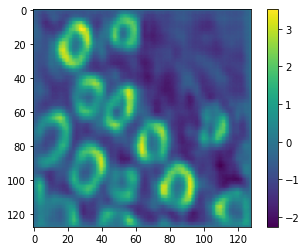

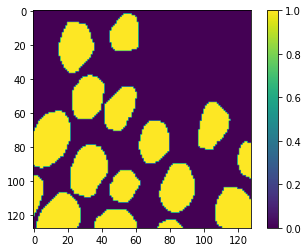

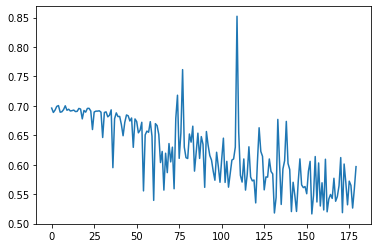

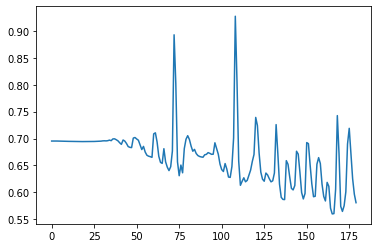

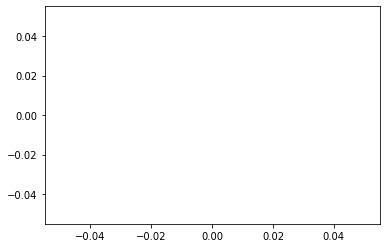

In [95]:
num = 0
print(final_pred.shape) 
print(final_batch.shape) 
plt.figure(1) 
plt.imshow(final_pred[num, :, :].detach().cpu()) 
plt.colorbar() 
plt.figure(2) 
plt.imshow(final_batch[num, :, :].detach().cpu()) 
plt.colorbar() 
plt.figure(3) 
plt.plot(bcetrain) 
plt.figure(4) 
plt.plot(bcetest) 
plt.figure(5) 
plt.plot(dicescore) 